In [21]:
import pandas as pd
import nltk
from bs4 import BeautifulSoup
from collections import Counter
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np
from gensim.models import Word2Vec
import pyLDAvis.gensim
from gensim import corpora
from gensim.models import LsiModel, LdaModel
import gensim.downloader as api
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
import gensim
from gensim.models import Word2Vec 
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from gensim.models.callbacks import PerplexityMetric
import spacy

In [7]:
df = pd.read_csv('kaggle_data/Emails.csv')

print(f'Total emails extracted: {df.shape[0]}')

Total emails extracted: 7945


In [6]:
df.dropna(subset=['ExtractedBodyText'], inplace=True)
print(f'Total emails extracted: {df.shape[0]}')

Total emails extracted: 6742


In [7]:
emails = df['ExtractedBodyText'].to_list()

In [8]:
emails = df['ExtractedBodyText'].to_list()
initial_emails = emails

emails = [BeautifulSoup(email_text.lower()).text for email_text in emails]
emails = [nltk.RegexpTokenizer(r'\w+').tokenize(email) for email in emails]

/usr/lib/python3/dist-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
/usr/lib/python3/dist-packages/bs4/__init__.py:282: UserWarning: "http://www.suntimes.com/2072121,desiree-rogers-quits-022610.article" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/lib/python3/dist-pack

In [10]:
word_lengths = np.array([len(word) for email in emails for word in email])
email_lengths = np.array([len(email) for email in emails])

There are 65 words with length > 18 (0.010525480569153216 perc)


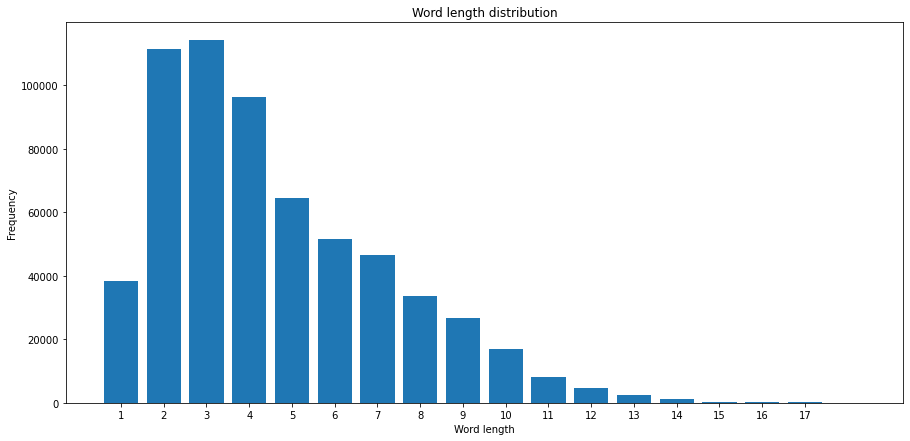

In [11]:
def print_word_len_distribution(arr, th):
    c = Counter(arr)

    plt.figure(figsize=(15, 7))
    keys = np.array(list(c.keys()))
    values = np.array(list(c.values()))
    
    if th is not None:
        big_len_cnt = np.sum(values[keys > th])
        perc = 100 * big_len_cnt / len(arr)
        print('There are %s words with length > %s (%s perc)' % (big_len_cnt, th, perc))

        values = values[keys <= th]
        keys = keys[keys <= th]

    plt.bar(keys, values)
    plt.title('Word length distribution')
    plt.xticks(range(min(keys), max(keys)))
    plt.xlabel('Word length')
    plt.ylabel('Frequency')
    plt.show()
    
print_word_len_distribution(word_lengths, 18)

There are 406 emails with length > 250 (6.021951943043607 perc)


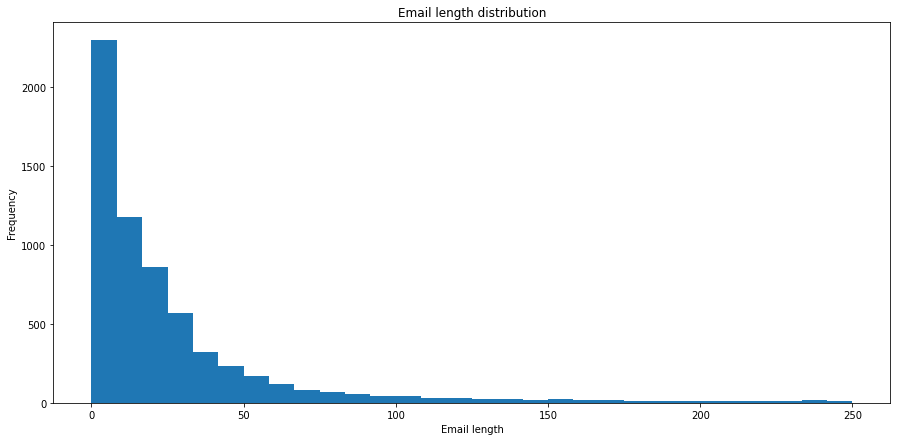

In [62]:
def print_email_len_distribution(arr, th):
    c = Counter(arr)
    
    cnt = np.sum(arr > th)
    perc = 100 * cnt / len(arr)
    print('There are %s emails with length > %s (%s perc)' % (cnt, th, perc))

    
    arr = arr[arr <= th]

    plt.figure(figsize=(15, 7))
    plt.hist(arr, bins=30)
    plt.title('Email length distribution')
    plt.xlabel('Email length')
    plt.ylabel('Frequency')
    plt.show()
    
print_email_len_distribution(email_lengths, 250)

In [13]:
def good_word(word):
    if len(word) < 3:
        return False
        
    if word in stop_words:
        return False
    
    for c in word:
        if '0' <= c <= '9':
            return False
        
    return True

In [30]:
nlp = spacy.load("en", disable=['parser', 'tagger', 'ner'])

def normalize(word):
    return nlp(word)[0].lemma_

normalize('dogs'), normalize('playing')

('dog', 'play')

In [31]:
stop_words = set(nltk.corpus.stopwords.words('english'))

emails = [
    [normalize(word) for word in email_words if good_word(word)]
    for email_words in emails]

emails = [email_words for email_words in emails if len(email_words) > 5]
print(f'Total emails extracted: {len(emails)}')

Total emails extracted: 3842


In [34]:
dictionary = corpora.Dictionary(emails)
corpus = [dictionary.doc2bow(email_words) for email_words in emails]

In [35]:
pps = []

rng = range(2, 11)
for num_topics in tqdm(rng):
    perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')

    lda = LdaModel(corpus, id2word=dictionary, num_topics=num_topics, callbacks=[perplexity_logger],
                   iterations=100, passes=5)

    pp = perplexity_logger.get_value()
    pps.append(pp)

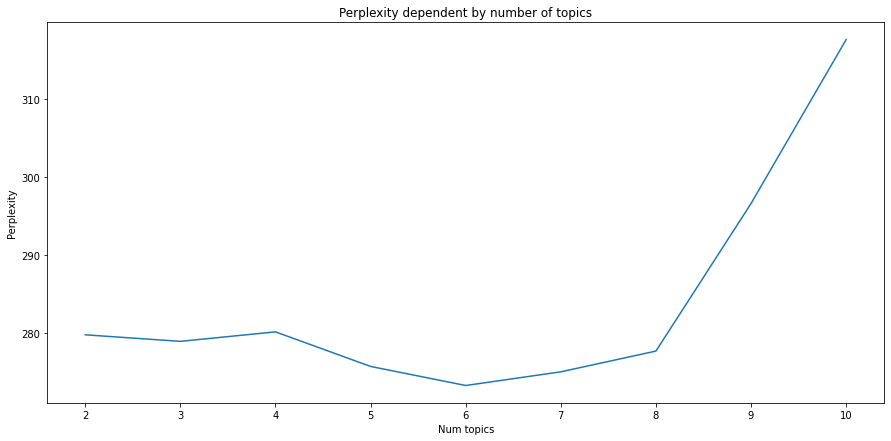

In [36]:
plt.figure(figsize=(15, 7))
plt.plot(rng, pps)
plt.xlabel('Num topics')
plt.ylabel('Perplexity')
plt.title('Perplexity dependent by number of topics')
plt.show()

In [63]:
best_num_topics = 6
lsi = LsiModel(corpus, id2word=dictionary, num_topics=best_num_topics)
lda = LdaModel(corpus, id2word=dictionary, num_topics=best_num_topics, iterations=100, passes=5)

In [64]:
    
def show(model):
    str_topics = [topic_w for topic_number, topic_w in model.print_topics()]
    str_topics_split = list(map(lambda x: x.split("+"), str_topics))
    str_topics_split = [list(map(lambda x: x.split("*")[1].strip()[1:-1], elem)) for elem in str_topics_split]
    for topic in str_topics_split:
        print(', '.join(topic))

In [46]:
show(lsi)

['state', 'say', 'one', 'obama', 'people', 'work', 'would', 'house', 'government', 'year']
['state', 'benghazi', 'say', 'department', 'obama', 'information', 'subject', 'agreement', 'sensitive', 'doc']
['senate', 'senator', 'vote', 'koch', 'israel', 'democrat', 'obama', 'say', 'republicans', 'american']
['koch', 'mcchrystal', 'afghanistan', 'kochs', 'charles', 'party', 'david', 'company', 'million', 'military']
['israel', 'mcchrystal', 'say', 'koch', 'jewish', 'american', 'israeli', 'peace', 'right', 'afghanistan']
['obama', 'israel', 'president', 'percent', 'white', 'favorable', 'secretary', 'house', 'koch', 'unfavorable']


In [65]:
show(lda)

secretary, office, state, meet, room, department, arrive, route, depart, private
state, information, benghazi, department, doc, case, subject, iran, agreement, house
call, get, say, see, know, work, want, would, think, time
cheryl, mill, gov, huma, abedin, fyi, sullivan, state, friday, sunday
say, obama, would, president, one, new, state, year, american, time
state, israel, woman, pakistan, afghanistan, would, make, settlement, need, security


In [48]:
data_lda = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(data_lda)

# Word2Vec word embeddings

In [ ]:
# model_glove_twitter = api.load("glove-twitter-50").wv

In [43]:
PATH = "/data/kirill/gensim-data/glove-twitter-50/glove-twitter-50"
model = KeyedVectors.load_word2vec_format(PATH)

In [44]:
model_2 = Word2Vec(size=50, min_count=1)
model_2.build_vocab(emails)
total_examples = model_2.corpus_count
model_2.build_vocab([list(model.vocab.keys())], update=True)
model_2.intersect_word2vec_format(PATH)

In [49]:
model_2.train(emails, total_examples=total_examples, epochs=100)

(31123700, 31123700)

In [50]:
words = np.array(list(set((" ".join([" ".join(x) for x in emails])).split())))

In [51]:
word_vectors = []
bad_count = 0
for x in words:
    try:
        vec = model_2.wv.get_vector(x)
    except KeyError:
        bad_count += 1
        vec = np.zeros(50)
    word_vectors.append(vec)

In [52]:
kmeans = KMeans(n_clusters=5, n_jobs=50)
kmeans.fit(word_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=50, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [53]:
for label in range(5):
    inds = np.where(kmeans.labels_ == label)
    print(words[inds][:20])
    print()

['interval' 'ponder' 'outline' 'falsify' 'memorabile' 'agreat' 'ambit'
 'incoherent' 'relatively' 'uproar' 'frankly' 'offing' 'stockpile'
 'evangelist' 'tiresome' 'undisclosed' 'treatise' 'evangelical' 'fiddle'
 'kochs']

['corzine' 'dibble' 'faso' 'debi' 'prelude' 'stuart' 'loy' 'htm' 'koy'
 'roberta' 'riverside' 'playwright' 'moses' 'tribeca' 'christopher' 'oes'
 'hayes' 'baku' 'serbian' 'dous']

['universalistic' 'darling' 'viral' 'claire' 'backbreaking' 'pfotenhauer'
 'sheet' 'leggfsv' 'loss' 'leguene' 'shakour' 'khalifa' 'flirt' 'resident'
 'specialkolumnsjpolinautfarchive' 'fuiianpnpval' 'etc' 'odein' 'pubiic'
 'qalibaf']

['etzion' 'multilateralism' 'yitzar' 'bellerive' 'time' 'sanei' 'tomicah'
 'anything' 'lasensky' 'quadrennial' 'speechwriting' 'adherent'
 'chaharmahal' 'work' 'khatami' 'videoconference' 'house' 'unpersuasive'
 'anteroom' 'gtaltimg']

['sorba' 'lowey' 'nocoll' 'chathamhouse' 'eikenberry' 'ganley'
 'maquiladoras' 'feltman' 'tauzin' 'karrubi' 'voinovich' 'valmor

In [54]:
word_vectors_pca = TSNE(n_components=2, n_jobs=50).fit_transform(word_vectors)
word_vectors_pca = StandardScaler().fit_transform(word_vectors_pca)

output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

Loading BokehJS ...

Figure(id='1003', ...)

In [55]:
word_vectors_pca[np.argmax(words == 'obama')]

array([-1.2547439,  1.023711 ], dtype=float32)

In [67]:
model_2.wv.most_similar('obama')

[('romney', 0.9429854154586792),
 ('barack', 0.9073218107223511),
 ('president', 0.8986026048660278),
 ('clinton', 0.8913119435310364),
 ('hillary', 0.8597259521484375),
 ('ipresident', 0.8448063731193542),
 ('says', 0.8407208323478699),
 ('havt', 0.8352546691894531),
 ('potus', 0.8337562680244446),
 ('hovv', 0.8315389752388)]

In [68]:
model_2.wv.most_similar('melania')

[('nadina', 0.885528564453125),
 ('estefany', 0.8776358366012573),
 ('shadia', 0.8678683638572693),
 ('yoly', 0.8673804998397827),
 ('sarahi', 0.8669494986534119),
 ('karmen', 0.8638578653335571),
 ('conni', 0.8621612191200256),
 ('manoli', 0.8585096001625061),
 ('anabella', 0.8549453020095825),
 ('nanci', 0.8540414571762085)]

In [69]:
model_2.wv.most_similar('trump')

[('appropriator', 0.7439741492271423),
 ('infighter', 0.7368026971817017),
 ('zappos', 0.7316897511482239),
 ('perkins', 0.7260088920593262),
 ('donald', 0.7180437445640564),
 ('buffett', 0.7113708853721619),
 ('harper', 0.7106218338012695),
 ('bloomberg', 0.7067334651947021),
 ('clinton', 0.7052138447761536),
 ('loeser', 0.70518559217453)]

In [66]:
model_2.wv.most_similar(positive=['melania', 'trump'])

[('ivanka', 0.7883167266845703),
 ('zappos', 0.77806556224823),
 ('sunita', 0.7757935523986816),
 ('glenda', 0.7645168900489807),
 ('karmen', 0.7590353488922119),
 ('ophelia', 0.7470037341117859),
 ('shadia', 0.7463523745536804),
 ('sutherland', 0.7439896464347839),
 ('thelma', 0.7429806590080261),
 ('margie', 0.7417060732841492)]

In [58]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [59]:
emails_text = [" ".join(x) for x in emails]

In [60]:
sentences = list(set(emails_text))
sentence_embeddings = model.encode(sentences)

In [61]:
def find_similar(src_vec, vecs):
    best_index = 10 ** 9
    best_dist = 10 ** 9
    for i, vec in enumerate(vecs):
        dist = np.mean((src_vec - vec) ** 2)
        if 1e-10 < dist < best_dist:
            best_dist = dist
            best_index = i
    return best_index

for num in range(20):
    if len(sentences[num]) > 50:
        continue
        
    print('Source sentence:  %s' % sentences[num])
    
    ind = find_similar(sentence_embeddings[num], sentence_embeddings) 
    print('Closest sentence: %s' % sentences[ind])
    print()

Source sentence:  release part fyi hope nice day great trip
Closest sentence: sure srap forward hope trip go good

Source sentence:  abedin huma tuesday october note hrc bono fyi
Closest sentence: context mill cheryl tuesday october thank

Source sentence:  fyi interest sure background happy give cdm
Closest sentence: nice high praise indeed cong record prosperity

Source sentence:  mill cheryl saturday may monday well
Closest sentence: cdm mill cheryl saturday may monday well

Source sentence:  murtha office still check whether something friday
Closest sentence: holbrooke still try determine handle though option appear limit late report

